The objective of this model is to be able to predict the GradeClass.

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
import mlflow
import pickle

In [36]:
data = pd.read_csv('data/Student_performance_data.csv')
data.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


# Exploratory Data Analysis


First of all, I will split the data in 3: training, validation and test.

In [37]:
X = data.drop(['GPA', 'GradeClass'], axis=1)
y = data[['GradeClass']]

In [38]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [39]:
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test)

Notes about the columns:

- The StudentID will be removed to avoid biases in the grade calculation.
- Age, Gender and Ethnicity will be dropped to avoid bias, but this must be consider in the posterior evaluation and to comply with the Responsible AI.

- StudyTimeWeekly and Absences need to be scaled. I will check if they are normally distributed.


Extra considerations:

- For the preprocessing, I will expect a dictionary with all the columns presented in the original dataframe, even though several of them will be dropped.
- Non missing values are expected.


## Preprocessing

Conclusions for the features :

- ParentalEducation and ParentalSupport are ordinal categorical variables and will be transformed with a MinMaxScaler.
- Since StudyTimeWeekly and Absences are more similar to uniform distribution than to a normal one, I will use the MinMaxScaler for both of them.

I will convert GradeClass through OneHotEncoding

In [40]:
data.columns

Index(['StudentID', 'Age', 'Gender', 'Ethnicity', 'ParentalEducation',
       'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport',
       'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GPA',
       'GradeClass'],
      dtype='object')

In [41]:
experiment_name = 'student-performance'
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='s3://mlflow-artifact-student-performance/1', creation_time=1720824921745, experiment_id='1', last_update_time=1720824921745, lifecycle_stage='active', name='student-performance', tags={}>

In [42]:
experiment_id = [experiment.experiment_id for experiment in mlflow.search_experiments() 
                 if experiment.name == 'student-performance']

In [43]:
from sklearn.preprocessing import MinMaxScaler


minmax_cols = ['ParentalEducation', 'StudyTimeWeekly',
                'Absences', 'ParentalSupport']
sc = MinMaxScaler()

x_sc_train = sc.fit_transform(X_train.loc[:, minmax_cols])
X_train.loc[:, minmax_cols] = x_sc_train

x_sc_val = sc.transform(X_val.loc[:, minmax_cols])
X_val.loc[:, minmax_cols] = x_sc_val

x_sc_test = sc.transform(X_test.loc[:, minmax_cols])
X_test.loc[:, minmax_cols] = x_sc_test
    
with open('minmax_scaler.bin', 'wb') as f_out:
    pickle.dump(sc, f_out)

C:\Users\Almudena\AppData\Local\Temp\ipykernel_25864\1457338884.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.75 0.   0.5  ... 0.25 0.5  0.5 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, minmax_cols] = x_sc_train
C:\Users\Almudena\AppData\Local\Temp\ipykernel_25864\1457338884.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.96551724 0.20689655 0.96551724 ... 0.44827586 0.27586207 0.65517241]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, minmax_cols] = x_sc_train
C:\Users\Almudena\AppData\Local\Temp\ipykernel_25864\1457338884.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.75 1.   0.75 ... 1.   0.25 0.25]' has dtype incompatible with i

We don't need for now this transformation due to the models we are going to use.


array([[<Axes: title={'center': 'GradeClass'}>]], dtype=object)

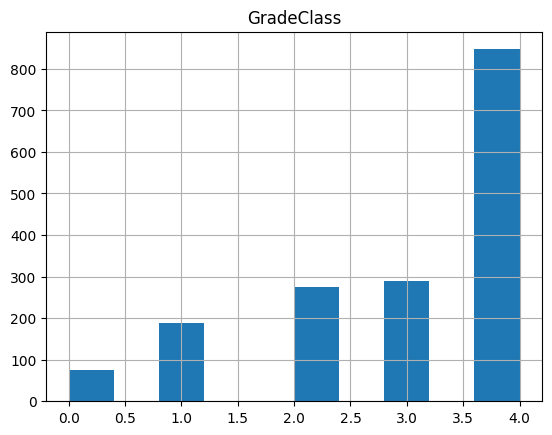

In [44]:
y_train.hist()

from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(sparse_output=False)
y_train = ohe.fit_transform(y_train)
y_val = ohe.transform(y_val)
y_test = ohe.transform(y_test)

In [45]:
X_train.isna().sum()


StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
dtype: int64

<Axes: >

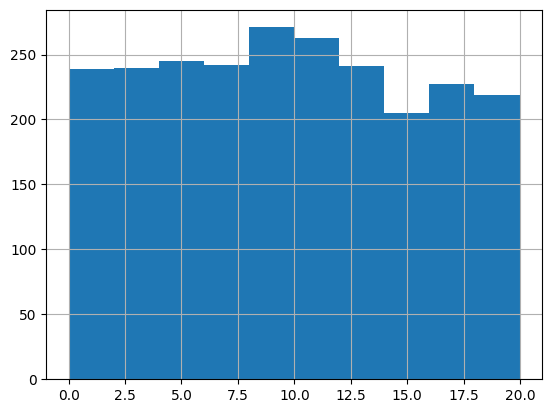

In [46]:
data.StudyTimeWeekly.hist()

<Axes: >

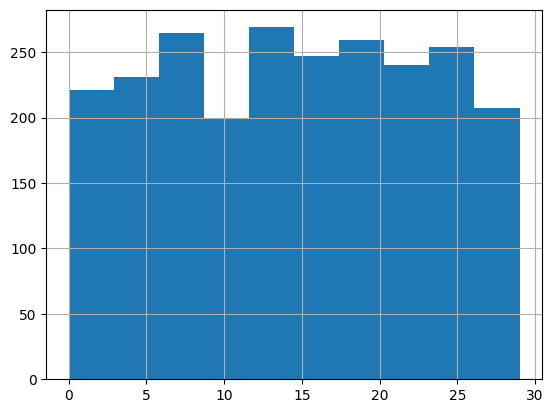

In [47]:
data.Absences.hist()

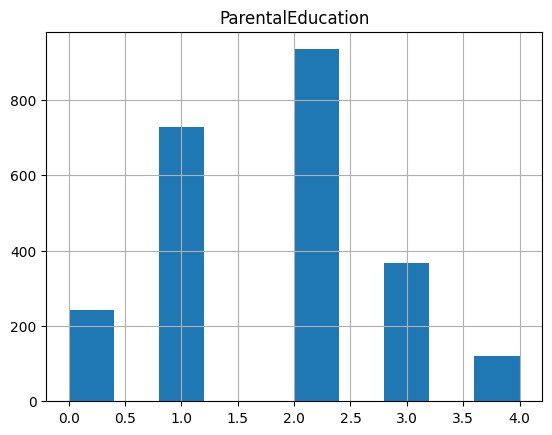

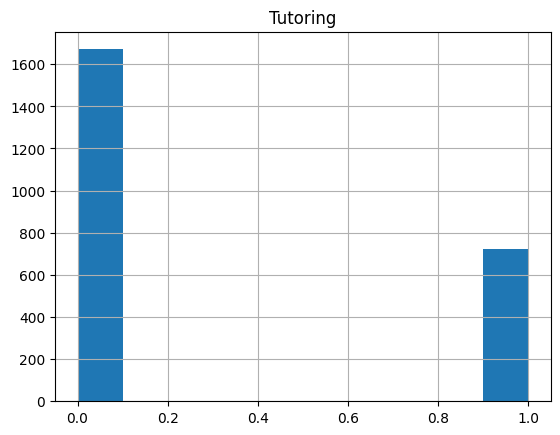

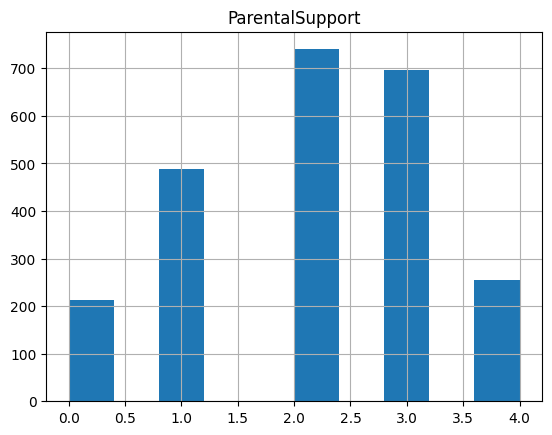

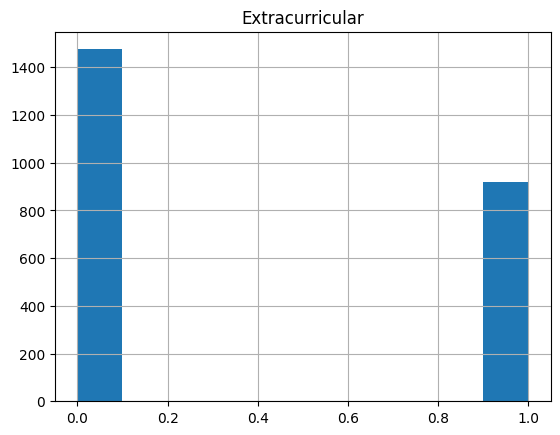

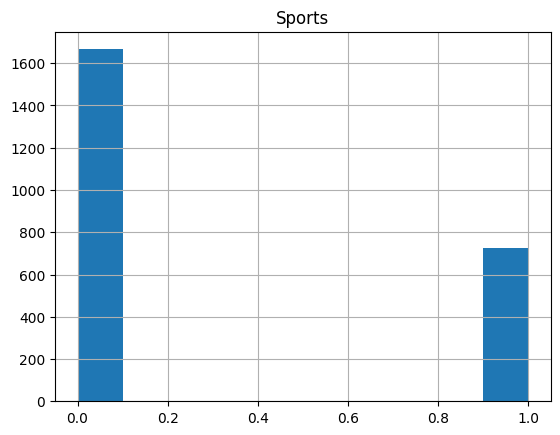

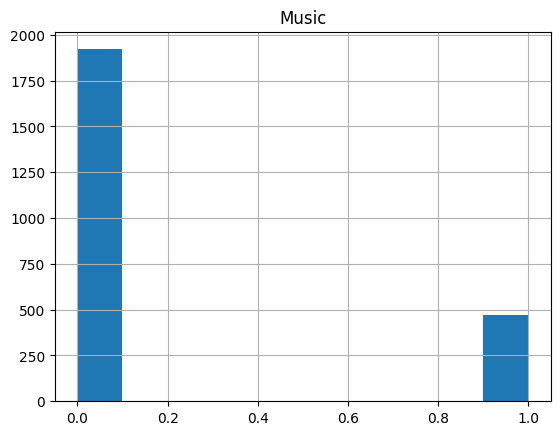

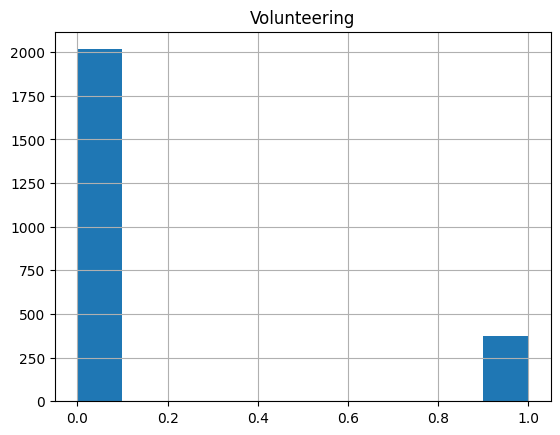

In [48]:
cat_columns = ['ParentalEducation', 'Tutoring', 'ParentalSupport',
                'Extracurricular', 'Sports', 'Music', 'Volunteering']


for col in cat_columns: 
    data[[col]].hist()

<Axes: >

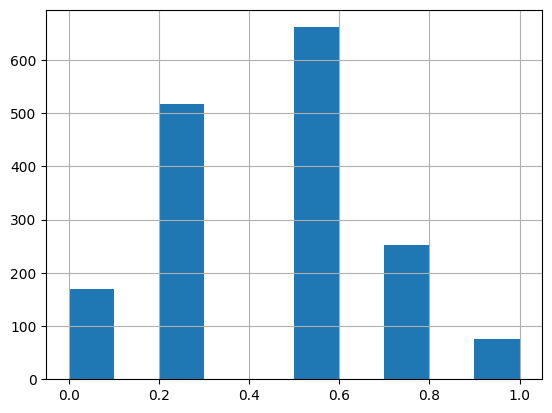

In [49]:
X_train.ParentalEducation.hist()

In [50]:
columns_to_drop = ['StudentID', 'Age', 'Gender', 'Ethnicity']


In [51]:
X_train.drop(columns_to_drop, axis=1, inplace=True)
X_val.drop(columns_to_drop, axis=1, inplace=True)
X_test.drop(columns_to_drop, axis=1, inplace=True)

# Model Training

In [52]:
import scipy.stats as stats

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [53]:
param_dists = [{
    'clf': [SVC()],
    'clf__C': stats.loguniform(1e-2, 1e3)
},
{
    'clf': [DecisionTreeClassifier()],
    'clf__criterion': ['gini','entropy'],
    'clf__splitter': ['best','random'],
    'clf__class_weight':['balanced', None]
},
{
    "clf": [SGDClassifier(loss="hinge", penalty="elasticnet", fit_intercept=True)],
    "clf__average": [True, False],
    "clf__l1_ratio": stats.uniform(0, 1),
    "clf__alpha": stats.loguniform(1e-2, 1e0),
}, 
{'clf': [RandomForestClassifier()],
 'clf__bootstrap': [True, False],
 'clf__max_depth': [10, 20, 30, None],
 'clf__min_samples_leaf': [1, 2, 4],
 'clf__min_samples_split': [2, 5, 10],
 'clf__n_estimators': stats.randint(20, 100)}]

In [54]:
n_iter_search = 10
n_cv = 5

results = {}

for param_dist in param_dists:
    print("-------------- " + str(param_dist) + " --------------")
    clf = param_dist['clf'][0]
    
    param_dist.pop('clf')
    steps = [('clf', clf)]
    random_search = RandomizedSearchCV(
        Pipeline(steps), param_distributions=param_dist,
          cv=n_cv, n_iter=n_iter_search, scoring='f1_macro'
    )
    random_search.fit(X_train, y_train.values.ravel())
    train_score = random_search.best_score_
    val_score = random_search.score(X_val, y_val.values.ravel())
    estimator_name = random_search.best_estimator_.steps[0][1].__class__
    results[estimator_name] = {'estimator': random_search.best_estimator_,
                               'mean_train_score': train_score, 'val_score': val_score}


-------------- {'clf': [SVC()], 'clf__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002EA14DA8910>} --------------
-------------- {'clf': [DecisionTreeClassifier()], 'clf__criterion': ['gini', 'entropy'], 'clf__splitter': ['best', 'random'], 'clf__class_weight': ['balanced', None]} --------------


e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


-------------- {'clf': [SGDClassifier(penalty='elasticnet')], 'clf__average': [True, False], 'clf__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002EA14D54520>, 'clf__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002EA1490ED90>} --------------
-------------- {'clf': [RandomForestClassifier()], 'clf__bootstrap': [True, False], 'clf__max_depth': [10, 20, 30, None], 'clf__min_samples_leaf': [1, 2, 4], 'clf__min_samples_split': [2, 5, 10], 'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002EA06336160>} --------------


In [55]:
pd.DataFrame(results)

,<class 'sklearn.svm._classes.SVC'>,<class 'sklearn.tree._classes.DecisionTreeClassifier'>,<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>,<class 'sklearn.ensemble._forest.RandomForestClassifier'>
estimator,(SVC(C=10.436256611818001)),(DecisionTreeClassifier(class_weight='balanced...,"(SGDClassifier(alpha=0.010039190976125104, l1_...","((DecisionTreeClassifier(max_depth=20, max_fea..."
mean_train_score,0.556928,0.496171,0.289972,0.581854
val_score,0.553415,0.453301,0.347831,0.57337


In [56]:
from sklearn.metrics import accuracy_score, roc_auc_score , f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [57]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('student-performance')

<Experiment: artifact_location='s3://mlflow-artifact-student-performance/1', creation_time=1720824921745, experiment_id='1', last_update_time=1720824921745, lifecycle_stage='active', name='student-performance', tags={}>

In [58]:
search_space = hp.choice('classifier_type', [
    {
        'type': 'svm',
        'C': hp.lognormal('SVM_C', 0, 1.0)
    },
    {
        'type': 'rf',
        'max_depth': hp.randint('rf_max_depth', 5, 100),
        'criterion': hp.choice('rf_criterion', ['gini', 'entropy'])
    },
    {
        'type': 'dt',
        'criterion': hp.choice('dt_criterion', ['gini','entropy']),
        'splitter': hp.choice('dt_splitter', ['best','random']),
        'class_weight':hp.choice('dt_class_weight', ['balanced', None])
    },
    {
        'type': 'xgb',
        'learning_rate': hp.choice('xgb_learning_rate', [0.0005,0.001, 0.01, 0.5, 1]),
        'max_depth' : hp.choice('xgb_max_depth', range(3,21,3)),
        'gamma' : hp.choice('xgb_gamma', [i/10.0 for i in range(0,5)]),
        'colsample_bytree' : hp.choice('xgb_colsample_bytree', [i/10.0 for i in range(3,10)]),     
        'reg_alpha' : hp.choice('xgb_reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
        'reg_lambda' : hp.choice('xgb_reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100]),
        'seed': hp.choice('xgb_seed', [0,7,42])
    }
])

In [59]:
def objective (params):
    with mlflow.start_run(nested=True):
        print(params)
        classifier_type = params['type']
        mlflow.set_tag("model", classifier_type)
        del params['type']
        if classifier_type == 'svm':
            clf = SVC(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)
        elif classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'xgb':
            clf = XGBClassifier(**params)
        else:
            return 0
        mlflow.log_params(params)

        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        f1 = f1_score(y_val, y_pred,  average='macro')
        mlflow.log_metric("f1_score", f1)

        if getattr(clf, 'predict_proba', None):
            y_pred_proba = clf.predict_proba(X_val)
            roc_auc = roc_auc_score(y_val, y_pred_proba, average='micro', multi_class='ovr')
            mlflow.log_metric("roc_auc", roc_auc)

        mlflow.sklearn.log_model(
            sk_model=clf,
            artifact_path="mlruns"
        )
        mlflow.log_artifact(local_path="minmax_scaler.bin", artifact_path="minmax_scaler")

    return {'loss': -f1, 'status': STATUS_OK } 

In [60]:
algo=tpe.suggest

with mlflow.start_run(nested=True):
    best_result = fmin(
      fn=objective, 
      space=search_space,
      algo=algo,
      max_evals=32,
      trials=Trials())

{'class_weight': 'balanced', 'criterion': 'entropy', 'splitter': 'best', 'type': 'dt'}
{'criterion': 'entropy', 'max_depth': 41, 'type': 'rf'}                           
  3%|▎         | 1/32 [00:08<04:11,  8.12s/trial, best loss: -0.43413066918542664]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'gini', 'max_depth': 92, 'type': 'rf'}                              
  6%|▋         | 2/32 [00:29<08:01, 16.04s/trial, best loss: -0.5630154631587793]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'colsample_bytree': 0.3, 'gamma': 0.3, 'learning_rate': 0.001, 'max_depth': 12, 'reg_alpha': 1, 'reg_lambda': 100, 'seed': 42, 'type': 'xgb'}
{'class_weight': 'balanced', 'criterion': 'entropy', 'splitter': 'best', 'type': 'dt'}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.5, 'max_depth': 12, 'reg_alpha': 1, 'reg_lambda': 10, 'seed': 0, 'type': 'xgb'}
{'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.001, 'max_depth': 15, 'reg_alpha': 100, 'reg_lambda': 0.1, 'seed': 0, 'type': 'xgb'}
{'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.0005, 'max_depth': 15, 'reg_alpha': 1, 'reg_lambda': 1, 'seed': 7, 'type': 'xgb'}
{'class_weight': 'balanced', 'criterion': 'gini', 'splitter': 'random', 'type': 'dt'}
{'class_weight': 'balanced', 'criterion': 'entropy', 'splitter': 'random', 'type': 'dt'}
{'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.0005, 'max_depth': 12, 'reg_alpha': 0.01, 'reg_lambda': 10, 'seed': 7, 'type': 'xgb'}
{'criterion': 'gini', 'max

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'C': 0.4620943795734277, 'type': 'svm'}                                          
 38%|███▊      | 12/32 [02:21<04:17, 12.85s/trial, best loss: -0.5754317864115805]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



{'class_weight': None, 'criterion': 'entropy', 'splitter': 'best', 'type': 'dt'}  
{'criterion': 'entropy', 'max_depth': 35, 'type': 'rf'}                           
 44%|████▍     | 14/32 [02:37<03:06, 10.36s/trial, best loss: -0.5754317864115805]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'class_weight': None, 'criterion': 'entropy', 'splitter': 'random', 'type': 'dt'}
{'C': 1.0744380947972922, 'type': 'svm'}                                          
 50%|█████     | 16/32 [03:05<03:08, 11.79s/trial, best loss: -0.5840909069589826]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



{'criterion': 'entropy', 'max_depth': 39, 'type': 'rf'}                           
 53%|█████▎    | 17/32 [03:13<02:39, 10.63s/trial, best loss: -0.5840909069589826]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'gini', 'max_depth': 88, 'type': 'rf'}                              
 56%|█████▋    | 18/32 [03:33<03:06, 13.35s/trial, best loss: -0.5840909069589826]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'gini', 'max_depth': 76, 'type': 'rf'}                              
 59%|█████▉    | 19/32 [03:53<03:19, 15.34s/trial, best loss: -0.5840909069589826]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'entropy', 'max_depth': 50, 'type': 'rf'}                           
 62%|██████▎   | 20/32 [04:13<03:23, 16.95s/trial, best loss: -0.5840909069589826]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'entropy', 'max_depth': 34, 'type': 'rf'}                           
 66%|██████▌   | 21/32 [04:34<03:18, 18.08s/trial, best loss: -0.5840909069589826]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'gini', 'max_depth': 50, 'type': 'rf'}                              
 69%|██████▉   | 22/32 [04:54<03:07, 18.76s/trial, best loss: -0.5840909069589826]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'entropy', 'max_depth': 10, 'type': 'rf'}                           
 72%|███████▏  | 23/32 [05:15<02:53, 19.24s/trial, best loss: -0.5840909069589826]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'C': 11.078175366022814, 'type': 'svm'}                                          
 75%|███████▌  | 24/32 [05:31<02:26, 18.36s/trial, best loss: -0.5902115680866478]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



{'criterion': 'entropy', 'max_depth': 10, 'type': 'rf'}                           
 78%|███████▊  | 25/32 [05:39<01:46, 15.26s/trial, best loss: -0.5902115680866478]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'entropy', 'max_depth': 10, 'type': 'rf'}                           
 81%|████████▏ | 26/32 [05:57<01:35, 15.91s/trial, best loss: -0.5902115680866478]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'entropy', 'max_depth': 35, 'type': 'rf'}                           
 84%|████████▍ | 27/32 [06:14<01:22, 16.41s/trial, best loss: -0.5902115680866478]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'C': 1.846466397855539, 'type': 'svm'}                                           
 88%|████████▊ | 28/32 [06:35<01:10, 17.61s/trial, best loss: -0.5902115680866478]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



{'criterion': 'entropy', 'max_depth': 64, 'type': 'rf'}                           
 91%|█████████ | 29/32 [06:43<00:44, 14.73s/trial, best loss: -0.5902115680866478]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'entropy', 'max_depth': 83, 'type': 'rf'}                           
 94%|█████████▍| 30/32 [07:02<00:32, 16.12s/trial, best loss: -0.5902115680866478]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



{'criterion': 'entropy', 'max_depth': 32, 'type': 'rf'}                           
 97%|█████████▋| 31/32 [07:22<00:17, 17.40s/trial, best loss: -0.5902115680866478]

e:\Documentos\Proyectos\Professional\mlops-student-performance\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



100%|██████████| 32/32 [07:42<00:00, 14.46s/trial, best loss: -0.5902115680866478]


In [61]:
import hyperopt


print(hyperopt.space_eval(search_space, best_result))

{'criterion': 'entropy', 'max_depth': 10, 'type': 'rf'}


In [62]:
from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient

In [63]:
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
run = client.search_runs(
  experiment_ids=experiment_id,
  run_view_type=ViewType.ACTIVE_ONLY,
  order_by=["metrics.accuracy DESC"]
)[0]
run

<Run: data=<RunData: metrics={'accuracy': 0.7437325905292479,
 'f1_score': 0.5840909069589826,
 'roc_auc': 0.9118644330816801}, params={'criterion': 'entropy', 'max_depth': '35'}, tags={'mlflow.log-model.history': '[{"run_id": "d595cb2f563d4f9786c471e9abf881cd", '
                             '"artifact_path": "mlruns", "utc_time_created": '
                             '"2024-07-23 16:25:33.148455", "flavors": '
                             '{"python_function": {"model_path": "model.pkl", '
                             '"predict_fn": "predict", "loader_module": '
                             '"mlflow.sklearn", "python_version": "3.9.6", '
                             '"env": {"conda": "conda.yaml", "virtualenv": '
                             '"python_env.yaml"}}, "sklearn": '
                             '{"pickled_model": "model.pkl", '
                             '"sklearn_version": "1.5.0", '
                             '"serialization_format": "cloudpickle", "code": '
         

In [64]:
run_id = run.info.run_id

mlflow.register_model(
    model_uri=f"runs:/{run_id}/models",
    name=experiment_name
)

Registered model 'student-performance' already exists. Creating a new version of this model...
2024/07/23 18:30:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: student-performance, version 2
Created version '2' of model 'student-performance'.


<ModelVersion: aliases=[], creation_timestamp=1721752238749, current_stage='None', description='', last_updated_timestamp=1721752238749, name='student-performance', run_id='d595cb2f563d4f9786c471e9abf881cd', run_link='', source='s3://mlflow-artifact-student-performance/1/d595cb2f563d4f9786c471e9abf881cd/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='2'>

In [65]:
model_uri = f"runs:/{run_id}/model"

model_src = RunsArtifactRepository.get_underlying_uri(model_uri)
filter_string = "run_id='{}'".format(run_id)
results = client.search_model_versions(filter_string)
model_version = results[0].version
model_version

'2'

In [66]:
new_stage = "Production"
client.transition_model_version_stage(
    name=experiment_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

C:\Users\Almudena\AppData\Local\Temp\ipykernel_25864\3224397365.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1721752238749, current_stage='Production', description='', last_updated_timestamp=1721752238835, name='student-performance', run_id='d595cb2f563d4f9786c471e9abf881cd', run_link='', source='s3://mlflow-artifact-student-performance/1/d595cb2f563d4f9786c471e9abf881cd/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='2'>